# Semana 4 — DBSCAN & HDBSCAN em dados não lineares

Comparação **K-Means vs DBSCAN vs HDBSCAN** em `make_moons` e `make_circles`.
Métricas: ARI (com rótulos verdadeiros) e Silhouette (quando aplicável).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score

# tentar importar HDBSCAN
try:
    import hdbscan
    HAS_HDBSCAN = True
except ImportError:
    HAS_HDBSCAN = False
    print('⚠️ hdbscan não encontrado. Instale com: pip install hdbscan')

⚠️ hdbscan não encontrado. Instale com: pip install hdbscan


In [2]:
def run_all(X, y, kmeans_k=2, dbscan_params=None, hdbscan_params=None, title=''):
    if dbscan_params is None: dbscan_params = {"eps": 0.3, "min_samples": 5}
    if hdbscan_params is None: hdbscan_params = {"min_cluster_size": 30, "min_samples": 5}

    Xs = StandardScaler().fit_transform(X)

    # KMeans
    km = KMeans(n_clusters=kmeans_k, n_init=10, random_state=42)
    km_labels = km.fit_predict(Xs)

    # DBSCAN
    db = DBSCAN(**dbscan_params)
    db_labels = db.fit_predict(Xs)

    # HDBSCAN (se disponível)
    if HAS_HDBSCAN:
        hdb = hdbscan.HDBSCAN(**hdbscan_params)
        hdb_labels = hdb.fit_predict(Xs)
    else:
        hdb_labels = None

    # métricas helper
    def metrics(Xs, y_true, labels):
        if labels is None: return {"ARI": np.nan, "Silhouette": np.nan}
        ari = adjusted_rand_score(y_true, labels)
        uniq = set(labels)
        if len(uniq - {-1}) >= 2:
            mask = (labels != -1)
            try:
                sil = silhouette_score(Xs[mask], labels[mask])
            except Exception:
                sil = np.nan
        else:
            sil = np.nan
        return {"ARI": ari, "Silhouette": sil}

    m_km  = metrics(Xs, y, km_labels)
    m_db  = metrics(Xs, y, db_labels)
    m_hdb = metrics(Xs, y, hdb_labels) if HAS_HDBSCAN else {"ARI": np.nan, "Silhouette": np.nan}

    # plot
    ncols = 3 if HAS_HDBSCAN else 2
    fig, axes = plt.subplots(1, ncols, figsize=(5*ncols, 4))
    axes = np.atleast_1d(axes)

    def plot_ax(ax, X, labels, title):
        if labels is None:
            ax.text(0.5, 0.5, 'HDBSCAN não instalado', ha='center', va='center')
            ax.set_axis_off()
            return
        uniq = np.unique(labels)
        n_colors = max(3, len(uniq))
        cmap = plt.get_cmap('tab20', n_colors)
        ax.scatter(X[:,0], X[:,1], c=labels, cmap=cmap, s=20)
        ax.set_title(title)
        ax.set_xlabel('x1'); ax.set_ylabel('x2')

    plot_ax(axes[0], Xs, km_labels, f'K-Means (k={kmeans_k})\nARI={m_km["ARI"]:.3f} | Sil={m_km["Silhouette"]:.3f}')
    plot_ax(axes[1], Xs, db_labels, f'DBSCAN {dbscan_params}\nARI={m_db["ARI"]:.3f} | Sil={m_db["Silhouette"]:.3f}')
    if HAS_HDBSCAN:
        plot_ax(axes[2], Xs, hdb_labels, f'HDBSCAN {hdbscan_params}\nARI={m_hdb["ARI"]:.3f} | Sil={m_hdb["Silhouette"]:.3f}')

    fig.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout(); plt.show()

    return pd.DataFrame({
        "Model": ["KMeans", "DBSCAN"] + (["HDBSCAN"] if HAS_HDBSCAN else []),
        "ARI":   [m_km["ARI"], m_db["ARI"]] + ([m_hdb["ARI"]] if HAS_HDBSCAN else []),
        "Silhouette": [m_km["Silhouette"], m_db["Silhouette"]] + ([m_hdb["Silhouette"]] if HAS_HDBSCAN else [])
    })

## 1) make_moons (onde DBSCAN/HDBSCAN brilham)

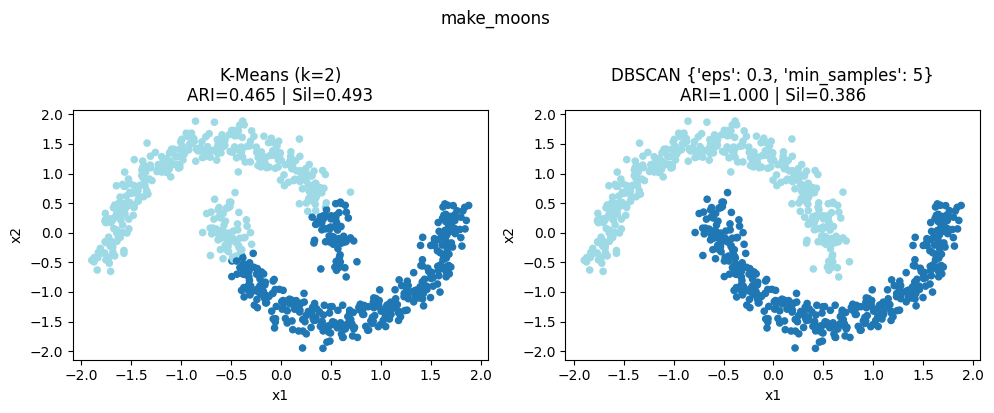

,Model,ARI,Silhouette
0,KMeans,0.465137,0.492639
1,DBSCAN,1.000000,0.386336


In [3]:
X_moons, y_moons = make_moons(n_samples=800, noise=0.08, random_state=42)

res_moons = run_all(
    X_moons, y_moons,
    kmeans_k=2,
    dbscan_params={"eps": 0.3, "min_samples": 5},
    hdbscan_params={"min_cluster_size": 30, "min_samples": 10},
    title='make_moons'
)
res_moons

## 2) make_circles (K-Means corta os anéis; DBSCAN/HDBSCAN respeitam a forma)

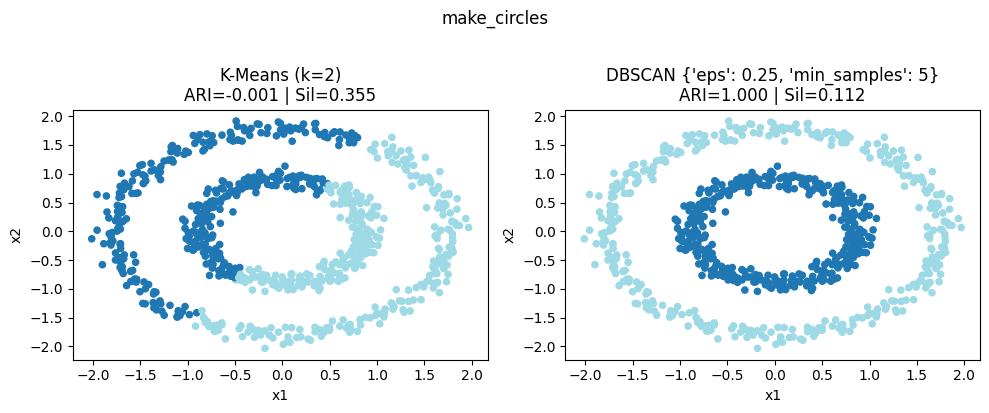

,Model,ARI,Silhouette
0,KMeans,-0.001197,0.355269
1,DBSCAN,1.000000,0.112276


In [4]:
X_circ, y_circ = make_circles(n_samples=800, factor=0.5, noise=0.05, random_state=42)

res_circ = run_all(
    X_circ, y_circ,
    kmeans_k=2,
    dbscan_params={"eps": 0.25, "min_samples": 5},
    hdbscan_params={"min_cluster_size": 30, "min_samples": 10},
    title='make_circles'
)
res_circ